## Expense Claim Patterns and Fraud Analysis (Flag 70)

### Dataset Description
The dataset consists of 500 entries simulating ServiceNow fm_expense_line table, which records various attributes of financial expenses. Key fields include 'number', 'opened_at', 'amount', 'state', 'short_description', 'ci', 'user', 'department', 'category', 'process_date', 'source_id', and 'type'. This table documents the flow of financial transactions by detailing the amount, departmental allocation, and the nature of each expense. Provides a clear view of organizational expenditures across different categories, highlighting both the timing and the approval state of each financial entry.

### Your Task
**Goal**: To detect and investigate instances of repeated identical expense claims by individual users, determining whether these repetitions are fraudulent or due to misunderstandings of the expense policy.

**Role**: Compliance and Audit Analyst

**Difficulty**: 3 out of 5.

**Category**: Finance Management


### Import Necessary Libraries
This cell imports all necessary libraries required for the analysis. This includes libraries for data manipulation, data visualization, and any specific utilities needed for the tasks. 

In [4]:
import argparse
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from openai import OpenAI
from pandas import date_range



### Load Dataset
This cell loads the expense dataset to be analyzed. The data is orginally saved in the from a CSV file, and is here imported into a DataFrame. The steps involve specifying the path to the dataset, using pandas to read the file, and confirming its successful load by inspecting the first few table entries.

In [5]:
dataset_path = "csvs/flag-70.csv"
flag_data = pd.read_csv(dataset_path)
df = pd.read_csv(dataset_path)
flag_data.head()

,source_id,department,number,amount,category,state,processed_date,type,user,opened_at,short_description,ci
0,QPK-03664835,Customer Support,EXP00000000,6240,Assets,Processed,2023-07-18 12:03:00.000000000,NaN,Helena Suermann,2023-07-17 12:03:00,Acquisition of new server hardware,IBM System x3550 M5
1,NaN,IT,EXP00000001,5947,Travel,Declined,NaN,NaN,Sadie Rowlett,2023-04-25 19:51:00,Travel equipment asset registration,Travel Kit 01
2,NaN,Sales,EXP00000002,2253,Miscellaneous,Declined,NaN,NaN,Nadia Wilshire,2023-05-03 02:19:00,Miscellaneous asset configuration item,Firewall FortiGate 50E
3,NaN,Sales,EXP00000003,2336,Miscellaneous,Processed,2023-04-22 07:45:28.895988932,NaN,Savannah Loffier,2023-04-11 04:45:00,Miscellaneous hardware asset creation,Desktop PC Dell Optiplex 3060
4,RKY-84503313,Finance,EXP00000004,6348,Assets,Declined,NaN,NaN,Germaine Bruski,2023-08-01 11:06:00,Asset Registration for New Hardware,Dell Latitude Laptop 5500


### **Question 1:How does the processing delay (time between "opened_at" and "processed_date") vary across different departments?**

#### Plot processing delay across departments
This analysis explores the efficiency of different departments in handling asset-related requests by examining the time delay between the request initiation (opened_at) and the processing completion (processed_date). Understanding this delay can highlight departments that might benefit from improved workflows for faster processing of requests or asset approvals.

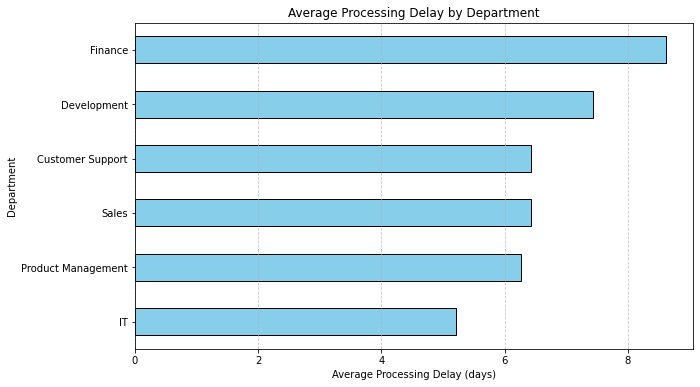

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Load and prepare data
data = pd.read_csv("csvs/flag-70.csv")
data["opened_at"] = pd.to_datetime(data["opened_at"], errors="coerce")
data["processed_date"] = pd.to_datetime(data["processed_date"], errors="coerce")

# Calculate the processing delay in days
data["processing_delay"] = (data["processed_date"] - data["opened_at"]).dt.days

# Drop rows with missing values in 'processing_delay' for better analysis
processed_data = data.dropna(subset=["processing_delay"])

# Group by department and calculate average processing delay
department_delay = (
    processed_data.groupby("department")["processing_delay"].mean().sort_values()
)

# Plotting
plt.figure(figsize=(10, 6))
department_delay.plot(kind="barh", color="skyblue", edgecolor="black")
plt.title("Average Processing Delay by Department")
plt.xlabel("Average Processing Delay (days)")
plt.ylabel("Department")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

#### Generate JSON Description for the Insight

In [7]:
{
    "data_type": "comparative",
    "insight": "Processing delays vary significantly across departments, with some departments handling requests faster on average than others.",
    "insight_value": {
        "description": "IT processes requests the fastest with an average delay of approximately 5.2 days, whereas Finance shows the longest delay, averaging around 8.6 days. This variation highlights potential inefficiencies and areas for improvement in Finance's request handling workflow."
    },
    "plot": {
        "plot_type": "horizontal bar chart",
        "title": "Average Processing Delay by Department",
        "x_axis": {
            "name": "Average Processing Delay (days)",
            "value": "Average delay in days ranging from around 5 to 9 days across departments",
            "description": "This axis represents the average time taken to process requests across different departments.",
        },
        "y_axis": {
            "name": "Department",
            "value": "Departments such as IT, Sales, Development, Finance, etc.",
            "description": "This axis lists the departments involved in handling requests or processing assets.",
        },
        "description": "The bar chart reveals differences in processing efficiency among departments, with IT displaying the shortest average delay and Finance showing the longest. This trend could suggest differences in resource allocation, priority, or process efficiency.",
    },
    "question": "How does the processing delay vary across different departments?",
    "actionable_insight": "To improve overall request processing efficiency, departments like Finance could benefit from reviewing and streamlining their workflows. Departments with faster processing times, like IT, might serve as models for process improvements. Cross-departmental process standardization could be a valuable approach to reduce delays and increase overall efficiency in request handling.",
}

{'data_type': 'comparative',
 'insight': 'Processing delays vary significantly across departments, with some departments handling requests faster on average than others.',
 'insight_value': {'description': "IT processes requests the fastest with an average delay of approximately 5.2 days, whereas Finance shows the longest delay, averaging around 8.6 days. This variation highlights potential inefficiencies and areas for improvement in Finance's request handling workflow."},
 'plot': {'plot_type': 'horizontal bar chart',
  'title': 'Average Processing Delay by Department',
  'x_axis': {'name': 'Average Processing Delay (days)',
   'value': 'Average delay in days ranging from around 5 to 9 days across departments',
   'description': 'This axis represents the average time taken to process requests across different departments.'},
  'y_axis': {'name': 'Department',
   'value': 'Departments such as IT, Sales, Development, Finance, etc.',
   'description': 'This axis lists the departments inv

### **Question 2:How many instances of any repeated identical expense claims are there?**


#### Frequency Distribution of Repeated Expense Claims

This chart analyzes frequency of repeated identical expense claims, highlighting potential anomalies. It focuses on claims submitted by the same user, within the same category, and for the same amount. The histogram displays the distribution of these frequencies, using red bars to highlight any unusual nature of repeated claims.



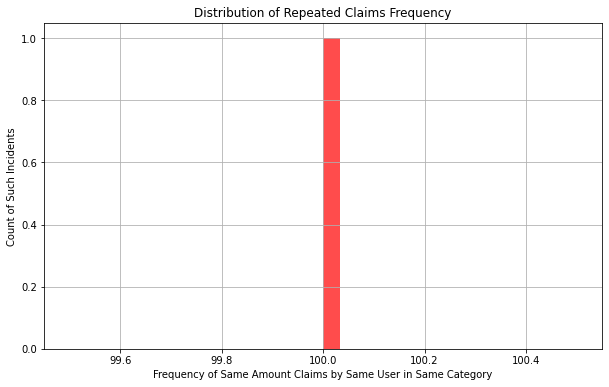

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by user, category, and amount to count occurrences
grouped_data = flag_data.groupby(['user', 'category', 'amount']).size().reset_index(name='frequency')

# Filter out normal entries to focus on potential anomalies
potential_fraud = grouped_data[grouped_data['frequency'] > 3]  # Arbitrary threshold, adjust based on your data

# Plot histogram of frequencies
plt.figure(figsize=(10, 6))
plt.hist(potential_fraud['frequency'], bins=30, color='red', alpha=0.7)
plt.title('Distribution of Repeated Claims Frequency')
plt.xlabel('Frequency of Same Amount Claims by Same User in Same Category')
plt.ylabel('Count of Such Incidents')
plt.grid(True)
plt.show()


#### Generate JSON Description for the Insight

In [9]:
{
    "data_type": "diagnostic",
    "insight": "There is a high incidence of repeated identical expense claims",
    "insight_value": {
        "description": "There are 100 instances where a single user has submitted identical claims with the same amount and category more than three times, which may indicate potential fraud or policy abuse within the expense management process."
    },
    "plot": {
        "plot_type": "histogram",
        "title": "Distribution of Repeated Claims Frequency",
        "x_axis": {
            "name": "Frequency of Same Amount Claims by Same User in Same Category",
            "value": "Frequency ranges",
            "description": "This axis represents the number of times the same expense claim has been submitted by the same user for the same amount in the same category."
        },
        "y_axis": {
            "name": "Count of Such Incidents",
            "value": "Number of occurrences",
            "description": "This axis counts the number of instances where repeated claims have occurred, highlighting the scale of potential repetitive claim submissions."
        },
        "description": "The histogram illustrates the frequency distribution of repeated expense claims, with a notable peak indicating 100 instances where claims have been repeatedly filed by the same user. This suggests a possible oversight or exploitation of the expense reporting system that warrants further investigation."
    },
    "question": "How many instances of repeated identical expense claims are there?",
    "actionable_insight": {
        "description": "Given the significant number of repeated claims, it is crucial for the organization to undertake a thorough review of these incidents to confirm their legitimacy and to determine if they reflect a pattern of fraud or abuse. Enhancing monitoring mechanisms, such as implementing automated flags for duplicate entries and conducting regular audits, could help prevent such behaviors. Training sessions emphasizing ethical practices and the consequences of policy violations should also be conducted to reinforce the seriousness of such actions. If fraudulent activities are confirmed, appropriate disciplinary measures should be enforced to maintain the integrity of the expense management system."
    }
}


{'data_type': 'diagnostic',
 'insight': 'There is a high incidence of repeated identical expense claims',
 'insight_value': {'description': 'There are 100 instances where a single user has submitted identical claims with the same amount and category more than three times, which may indicate potential fraud or policy abuse within the expense management process.'},
 'plot': {'plot_type': 'histogram',
  'title': 'Distribution of Repeated Claims Frequency',
  'x_axis': {'name': 'Frequency of Same Amount Claims by Same User in Same Category',
   'value': 'Frequency ranges',
   'description': 'This axis represents the number of times the same expense claim has been submitted by the same user for the same amount in the same category.'},
  'y_axis': {'name': 'Count of Such Incidents',
   'value': 'Number of occurrences',
   'description': 'This axis counts the number of instances where repeated claims have occurred, highlighting the scale of potential repetitive claim submissions.'},
  'descri

### **Question 3:  Which users are involved in the frequent cases?**


#### Plot repeated expense claims by user and category

This plot visualizes repeated expense claims across various categories, highlighting users involved in frequent submissions. Each dot represents a unique combination of user, category, and expense amount, with the size of the dot proportional to the frequency of claims.


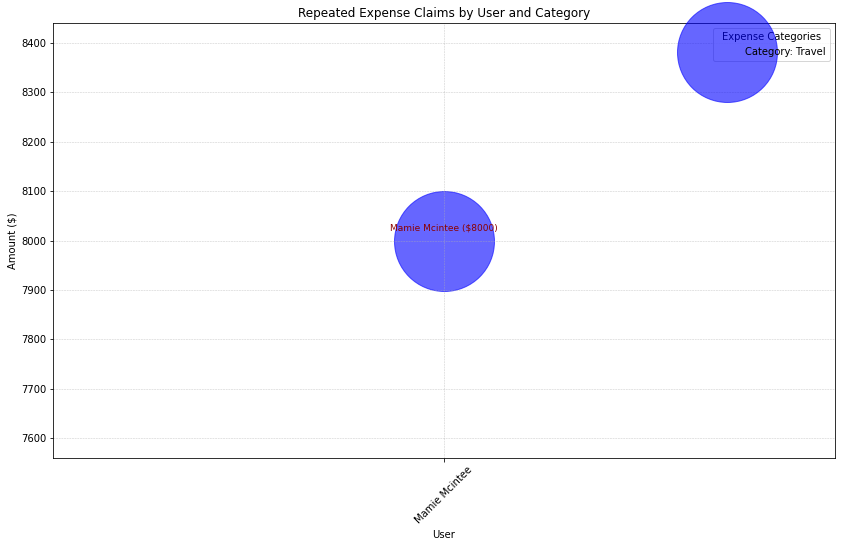

In [10]:
import matplotlib.pyplot as plt

# Assume flag_data includes 'user', 'amount', 'category' columns
# Group data by user, category, and amount to count frequencies
grouped_data = flag_data.groupby(['user', 'category', 'amount']).size().reset_index(name='count')

# Filter to only include cases with more than one claim (to highlight potential fraud)
repeated_claims = grouped_data[grouped_data['count'] > 1]

# Create a scatter plot with sizes proportional to the count of claims
plt.figure(figsize=(14, 8))
colors = {'Travel': 'blue', 'Meals': 'green', 'Accommodation': 'red', 'Miscellaneous': 'purple'}  # Add more categories as needed
for ct in repeated_claims['category'].unique():
    subset = repeated_claims[repeated_claims['category'] == ct]
    plt.scatter(subset['user'], subset['amount'], s=subset['count'] * 100,  # Increased size factor for better visibility
                color=colors.get(ct, 'gray'), label=f'Category: {ct}', alpha=0.6)

# Customizing the plot
plt.title('Repeated Expense Claims by User and Category')
plt.xlabel('User')
plt.ylabel('Amount ($)')
plt.legend(title='Expense Categories')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Highlighting significant cases
# Let's annotate the specific user found in your description
for i, row in repeated_claims.iterrows():
    if row['user'] == 'Mamie Mcintee' and row['amount'] == 8000:
        plt.annotate(f"{row['user']} (${row['amount']})", (row['user'], row['amount']),
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='darkred')

# Show plot
plt.show()


#### Generate JSON Description for the Insight

In [11]:
{
    "data_type": "diagnostic",
    "insight": "There is a significant repetition in expense claims by a single user",
    "insight_value": {
        "description": "A user named Mamie Mcintee has repeatedly submitted identical claims for $8000, suggesting potential issues of policy abuse or fraudulent behavior."
    },
    "plot": {
        "plot_type": "scatter",
        "title": "Repeated Expense Claims by User and Category",
        "x_axis": {
            "name": "User",
            "value": "Unique user identifiers",
            "description": "This axis represents the users who have submitted expense claims."
        },
        "y_axis": {
            "name": "Amount ($)",
            "value": "Amount of each expense claim",
            "description": "This axis displays the monetary amount of the claims, highlighting repeated identical submissions by certain users."
        },
        "description": "The scatter plot visualizes the frequency and distribution of repeated expense claims, with emphasis on specific users like Mamie Mcintee who have submitted multiple identical claims. The use of different colors for categories and the annotations provide a clear visual indication of the problematic patterns that may require further investigation."
    },
    "question": "Which users are involved in the frequent cases?",
    "actionable_insight": {
        "description": "The consistent pattern of repeated identical high-value claims by a particular user warrants a thorough investigation to determine the legitimacy of these submissions. The organization should review the related documents and approval processes involved with these claims. Enhanced monitoring mechanisms and possibly revising the expense submission guidelines or training could prevent such potentially abusive practices. If fraudulent activity is confirmed, appropriate disciplinary actions should be taken to deter such behavior and uphold the integrity of the expense management process."
    }
}


{'data_type': 'diagnostic',
 'insight': 'There is a significant repetition in expense claims by a single user',
 'insight_value': {'description': 'A user named Mamie Mcintee has repeatedly submitted identical claims for $8000, suggesting potential issues of policy abuse or fraudulent behavior.'},
 'plot': {'plot_type': 'scatter',
  'title': 'Repeated Expense Claims by User and Category',
  'x_axis': {'name': 'User',
   'value': 'Unique user identifiers',
   'description': 'This axis represents the users who have submitted expense claims.'},
  'y_axis': {'name': 'Amount ($)',
   'value': 'Amount of each expense claim',
   'description': 'This axis displays the monetary amount of the claims, highlighting repeated identical submissions by certain users.'},
  'description': 'The scatter plot visualizes the frequency and distribution of repeated expense claims, with emphasis on specific users like Mamie Mcintee who have submitted multiple identical claims. The use of different colors for ca

### **Question 4:  What department and categories are most commonly involved in these repeated claims?**


#### Plot distribution of expense claims by department and category for Mamie Mcintee

This bar graph displays the distribution of Mamie Mcintee's expense claims across different departments and categories, illustrating the specific areas where repeated claims are most frequent. One color represents a different expense category, allowing for a clear view of which combinations are most problematic.


<Figure size 864x504 with 0 Axes>

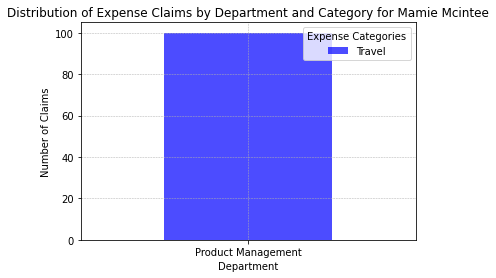

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'flag_data' includes 'user', 'department', 'amount', 'category' columns
# and it's already loaded with the data

# Filter for the specific user
user_data = flag_data[flag_data['user'] == 'Mamie Mcintee']

# Group data by department and category to count frequencies
department_category_counts = user_data.groupby(['department', 'category']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 7))
department_category_counts.plot(kind='bar', stacked=True, color=['blue', 'green', 'red', 'purple', 'orange'], alpha=0.7)
plt.title('Distribution of Expense Claims by Department and Category for Mamie Mcintee')
plt.xlabel('Department')
plt.ylabel('Number of Claims')
plt.xticks(rotation=0)  # Keep the department names horizontal for better readability
plt.legend(title='Expense Categories')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


#### Generate JSON Description for the Insight

In [13]:
{
    "data_type": "Descriptive",
    "insight": "There is a concentration of repeated claims in the Travel category",
    "insight_value": {
        "description": "Mamie Mcintee’s repeated identical expense claims are not only submitted under her department but are specifically concentrated in the Travel category, raising concerns about potential policy abuse or fraudulent activities within this particular expense category."
    },
    "plot": {
        "plot_type": "bar",
        "title": "Expense Claims by Department and Category for Mamie Mcintee",
        "x_axis": {
            "name": "Department",
            "value": "Identified department(s)",
            "description": "This axis displays the department under which Mamie Mcintee has submitted her claims, with a focus on the Travel category."
        },
        "y_axis": {
            "name": "Number of Claims",
            "value": "Total claims segmented by category, highlighting Travel",
            "description": "This axis counts the claims, specifically highlighting the frequency of claims within the Travel category, demonstrating a significant focus in this area."
        },
        "description": "The stacked bar chart clearly illustrates that Mamie Mcintee's repeated expense claims are primarily within the Travel category. This specific concentration suggests a pattern that may require further investigation to ensure these claims are legitimate and within company policies."
    },
    "question": "Confirm that these expenses are submitted under the department?",
    "actionable_insight": {
        "description": "Given the concentration of repeated claims in the Travel category, it is advisable for the organization to conduct an in-depth review of all Travel-related expense submissions by Mamie Mcintee. This review should include verifying the authenticity of the claims and assessing compliance with the travel expense policies. Implementing more stringent controls and possibly providing additional training on appropriate expense reporting for travel could help mitigate the risk of fraud and ensure that such patterns do not indicate policy abuse. Regular audits and real-time monitoring of expense submissions in high-risk categories like Travel are also recommended to maintain the integrity of the expense management system."
    }
}


{'data_type': 'Descriptive',
 'insight': 'There is a concentration of repeated claims in the Travel category',
 'insight_value': {'description': 'Mamie Mcintee’s repeated identical expense claims are not only submitted under her department but are specifically concentrated in the Travel category, raising concerns about potential policy abuse or fraudulent activities within this particular expense category.'},
 'plot': {'plot_type': 'bar',
  'title': 'Expense Claims by Department and Category for Mamie Mcintee',
  'x_axis': {'name': 'Department',
   'value': 'Identified department(s)',
   'description': 'This axis displays the department under which Mamie Mcintee has submitted her claims, with a focus on the Travel category.'},
  'y_axis': {'name': 'Number of Claims',
   'value': 'Total claims segmented by category, highlighting Travel',
   'description': 'This axis counts the claims, specifically highlighting the frequency of claims within the Travel category, demonstrating a significa

### Summary of Findings (Flag 70):

1. **Processing Delays Across Departments**: From Question 1, it was found that processing delays vary significantly across departments. IT processes requests the fastest, while Finance shows the longest delays, indicating potential inefficiencies in Finance's workflow.

2. **Repeated Identical Claims**: Question 2 highlighted a high incidence of repeated identical expense claims, with 100 instances where a single user submitted identical claims more than three times. This suggests potential fraud or policy abuse.

3. **User-Specific Anomalies**: Question 3 revealed that a user named Mamie Mcintee has repeatedly submitted identical claims for $8000, particularly in the Travel category. This pattern suggests possible policy abuse or fraudulent behavior that requires further investigation.